#Laborator 4

In cadrul acestui laborator o sa lucram cu blocurile de baza necesare construirii unor retele mai complexe. De interes sunt:


*   Residual Blocks
*   Inception Blocks

Pe langa acestea, o sa aplicam si augmentari generale de date care au rolul de a face modelul robust la variatii mici. 



## Operatii Noi

Urmatoarele operatii vor fi folosite in cadrul laboratorului

Tensor shape: (batch,channels,dim1,dim2)


*  **torch.cat(tensors, dim=0).** Tensorii trebuie sa aiba aceleasi dim1,dim2, dar channels poate sa difere.
*  **torch.add(input, other)**. Tensorii trebuie sa aiba aceleasi dimensiune pe toate axele.





In [6]:
import numpy as np
import torch.nn as nn
import torch

dummy_input_tensor1 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1,5,100,100))  # Input random de marime 100x100 cu 5 canale

# Normal se concateneaza pe dimensiunea canalelor.
x = torch.cat([dummy_input_tensor1,dummy_input_tensor2],dim=1) 
print(x.shape) # Numarul de canele_output = canale_input2 + canale_input1

dummy_input_tensor1 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale

x = torch.add(dummy_input_tensor1,dummy_input_tensor2)
print(x.shape) 

torch.Size([1, 8, 100, 100])
torch.Size([1, 3, 100, 100])


##Residual Block

In cadrul Resnet se utilizeaza residual connections / skip connections, care impreuna cu un path normal, ca cele implementate pana acum, formeaza un residual block. 

![resnetBlock](https://drive.google.com/uc?id=1fa4uuMBY4qmDbk4Tanu3CT-1E4nYq_He)

###Cerinta 1 - **(3p)**

Implementati ResidualBlock. Acesta duce input tensor in ($c_{input}$,width,height) in  ($c_{out}$,width,height) sau  ($c_{out}$,width/2,height/2) in functie de stride.




In [165]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F

class ResidualBlock(nn.Module):
  def __init__(self,input_channels=32,hidden_channels=64,output_channels=64,kernel_size=3,stride=1,activation=nn.ReLU()):
    super(ResidualBlock,self).__init__()
    layers = []
    # Your code here
    layers.append(nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2))
    layers.append(activation)
    # layers.append(nn.Conv2d(in_channels= hidden_channels, out_channels=output_channels,kernel_size=kernel_size, stride=stride, padding=kernel_size//2))

    self.net_normal = nn.Sequential(*layers)

    self.net_residual = nn.Conv2d(input_channels,output_channels,1,stride)

  def forward(self,x):
    x = torch.add(self.net_normal(x),self.net_residual(x))
    x = F.relu(x)
    return x

block = ResidualBlock(3,64,128,3,2,nn.ReLU())
block2 = ResidualBlock(128,64,128,3,2,nn.ReLU())
x = torch.rand(size=(1,3,100,100))
conv = nn.Conv2d(128,128,3,2)
# Should output torch.Size([1, 256, 50, 50])
print(conv(block2(block(x))).shape)

torch.Size([1, 128, 12, 12])


##Inception Block

In cadrul GoogleNet/InceptionNet este folosit Inception Block, care este alcatuit din mai multe mini-retele putin diferite, care se unesc la finalul Inception Block

### Cerinta 2 - **(3p)**

Implementati Inception Block. Acesta trebuie sa duca un Tensor ($ch_{input}$,w,h) in ($ch_{out}$,w/2,h/2)

![InceptionBlock](https://drive.google.com/uc?id=1OOLqfHZSIdQp6xO1T8cUpgjmfkMgGDuU)

In [202]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F


class InceptionBlock(nn.Module):
  def __init__(self,input_channels=32,kernel_size=3,stride=1,activation=nn.ReLU()):
    super(InceptionBlock,self).__init__()
    ## De sters
    layers = []
    # Your code here
    params = [[1,input_channels//4,input_channels,stride,0],[3,input_channels//2,input_channels//4,1,1],[3,input_channels,input_channels//2,1,1]]
    for param in params:
      layers.append(nn.Conv2d(param[2],param[1],param[0],param[3],(param[4],param[4])))
      layers.append(nn.BatchNorm2d(param[1]))
      layers.append(activation)
    self.path1 = nn.Sequential(*layers)

    layers = []
    # Your code here
    params2 = [[1, input_channels//4, input_channels,stride,0], [3, input_channels//2, input_channels//4,1,1]]
    for param2 in params2:
      layers.append(nn.Conv2d(param2[2], param2[1], param2[0],param2[3],padding=(param2[4],param2[4])))
      layers.append(nn.BatchNorm2d(param2[1]))
      layers.append(activation)
    self.path2 = nn.Sequential(*layers)

    layers = []
    # Your code here
    layers.append(nn.MaxPool2d(3,1))
    layers.append(nn.Conv2d(input_channels,input_channels//4,1,stride,padding=(1,1)))
    layers.append(nn.BatchNorm2d(input_channels//4))
    layers.append(activation)
    self.path3 = nn.Sequential(*layers)

    layers = []
    # Your code here
    layers.append(nn.Conv2d(input_channels,input_channels//4,1,stride ))
    layers.append(nn.BatchNorm2d(input_channels//4))
    layers.append(activation)
    self.path4 = nn.Sequential(*layers)

  def forward(self,x):
    x1 = self.path1(x)
    # print(x1.shape)
    x2 =self.path2(x)
    # print(x2.shape)
    x3 =self.path3(x)
    # print(x3.shape)
    x4 =self.path4(x)
    # print(x4.shape)
    x = torch.cat([x1,x2,x3,x4],1)
    return x

block = InceptionBlock(64,3,2,nn.ReLU())
x = torch.rand(size=(1,64,100,100))

# Should output torch.Size([1, 128, 50, 50])
print(block(x).shape)

torch.Size([1, 128, 50, 50])


In [9]:
x = torch.rand(size=(1,64,100,100))
y = torch.rand(size=(1,64,100,100))

torch.cat([x,y],dim=1).shape

torch.Size([1, 128, 100, 100])

## Instantierea seturilor de date

In acest laborator lucram cu un nou set de date. Este vorba de un dataset folosit in [aceasta competitie Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview), Pisici vs Caini. 

***In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.***


# Descarcarea setului de date

### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.


In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!pip install kaggle
!kaggle competitions download -c dogs-vs-cats
!for z in *.zip; do unzip "$z"; done
!ls 

## Crearea Dataloader-ului

In continuare, pentru a incarca date, sa o folosim un obiect mai complex, un Torch.utils.data.Dataset. Acesta are 3 functii importante:


*   __init__()
*   ____len____()
*  ____get_item____()



In [54]:
import torch as t
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random, os
random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

train_dir = '../data/train'
test_dir = '../data/test'

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, width=128, height=128, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.img_size = (width, height)
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        original_width, original_height = img.size

        img = img.resize(self.img_size)
        img = np.array(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return to_tensor(img), label

Construire Dataset si vizualizare date.

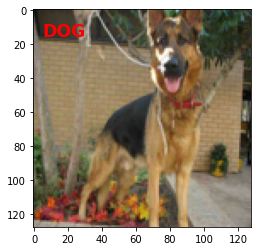

In [140]:
from IPython.display import clear_output
import time

train_test_proportion = .85

import glob

samples = glob.glob(os.path.join('./train','*.jpg'))
random.shuffle(samples)

train_samples = samples[:int(train_test_proportion*len(samples))]
test_samples = samples[int(train_test_proportion*len(samples)):]

cats_dogs_train = CatsDogsDataset(train_samples)
cats_dogs_test = CatsDogsDataset(test_samples)

train_loader = DataLoader(cats_dogs_train, batch_size=16, shuffle=True)
test_loader = DataLoader(cats_dogs_test, batch_size=1, shuffle=False)

see_examples = 10
for i, (imgs, label) in enumerate(test_loader):
    clear_output(wait=True)
    plt.imshow(imgs[0].permute(1, 2, 0))
    plt.text(5, 15, "DOG" if label[0] else "CAT", fontsize ='xx-large', color='red', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)


In [51]:
train_samples[0]

'./train/cat.11754.jpg'

In [134]:
# Antrenati o retea convolutionala (o arhitectura la alegere din laboratorul 3) folosind acest dataset, pe GPU
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=(2,2))
    self.layer2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=(3,3), stride=(2,2))
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(4805,500)
    self.linear2 = nn.Linear(500,1) #noi avem 32x32x3, deci (32-2):2 aka (32-kernel_size-1)/stride
    self.activation = nn.ReLU() 
  def forward(self,x):
    output_layer1 = self.layer1(x)
    output1 = self.activation(output_layer1)
    output_layer2 = self.layer2(output1)
    # print(output_layer2.shape)
    output2 = self.flatten(output_layer2)
    output2 = self.activation(output2)
    output_linear = self.activation(self.linear1(output2))
    output_linear = self.linear2(output_linear)
    output = torch.sigmoid(output_linear)
    return output

In [160]:
import torch.optim as optim

# Definiti numarul de epoci
epochs = 5

# Definiti reteaua
net = Net().cuda()

# Definiti optimizatorul
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici
optimizer.zero_grad()


# Definiti functia cost pentru clasificare Cross-Entropy
loss_fn = nn.BCELoss()


In [161]:
def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader):
  use_cuda = True
  # Iteram prin numarul de epoci
  for e in range(epochs):
    # Iteram prin fiecare exemplu din dataset
    for images, labels in train_loader:
      if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      loss = loss_fn(out, labels.cuda().reshape(-1,1).float())
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()
    
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e, loss.item()))

    # Caluculul acuratetii
    count = len(test_loader)
    correct = 0

    for test_image, test_label in test_loader:
      if use_cuda:
        test_label = test_label.cuda()
        test_image = test_image.cuda()
      out_class = (net(test_image) > .5).float()
      if out_class == test_label:
        correct += 1

    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e, (correct / count) * 100))

In [162]:
train_fn(epochs, train_loader, test_loader)

Loss-ul la finalul epocii 0 are valoarea 0.5292406678199768
Acuratetea la finalul epocii 0 este 62.93%
Loss-ul la finalul epocii 1 are valoarea 0.6555823683738708
Acuratetea la finalul epocii 1 este 66.19%
Loss-ul la finalul epocii 2 are valoarea 0.7733889818191528
Acuratetea la finalul epocii 2 este 67.04%
Loss-ul la finalul epocii 3 are valoarea 1.6742298603057861
Acuratetea la finalul epocii 3 este 69.63%
Loss-ul la finalul epocii 4 are valoarea 0.7446492910385132
Acuratetea la finalul epocii 4 este 70.11%


In [159]:
use_cuda = True
correct =0 
for test_image, test_label in test_loader:
  if use_cuda:
    test_label = test_label.cuda()
    test_image = test_image.cuda()
  out_class = (net(test_image) > .5).float()
  if out_class == test_label:
    correct += 1

print("Acuratetea la finalul epocii {} este {:.2f}%".format(0, (correct / len(test_loader)) * 100))

Acuratetea la finalul epocii 0 este 67.71%


# **Antrenati o retea de tip Resnet (folosind blocuri de tip Residual)**

In [228]:
import torch.nn as nn

class Residual(nn.Module):
  def __init__(self):
    super(Residual, self).__init__()
    self.layer1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=(3,3), stride=(2,2))
    self.layer2 = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(3,3), stride=(2,2))
    self.block = ResidualBlock(10,64,128,3,2,nn.ReLU())
    self.block2 = ResidualBlock(128,64,128,3,2,nn.ReLU())
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(8192,500)
    self.linear2 = nn.Linear(500,1) #noi avem 32x32x3, deci (32-2):2 aka (32-kernel_size-1)/stride
    self.activation = nn.ReLU() 
  def forward(self,x):
    output_layer1 = self.layer1(x)
    output1 = self.activation(output_layer1)
    output_layer2 = self.layer2(output1)
    output_block1 = self.block(output_layer2)
    output_block2 = self.block2(output_block1)
    output2 = self.flatten(output_block2)
    output_linear = self.activation(self.linear1(output2))
    output_linear = self.linear2(output_linear)
    output = torch.sigmoid(output_linear)


    return output

In [229]:
import torch.optim as optim

# Definiti numarul de epoci
epochs = 7

# Definiti reteaua
net = Residual().cuda()

# Definiti optimizatorul
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici
optimizer.zero_grad()


# Definiti functia cost pentru clasificare Cross-Entropy
loss_fn = nn.BCELoss()


In [230]:
def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader):
  use_cuda = True
  # Iteram prin numarul de epoci
  for e in range(epochs):
    # Iteram prin fiecare exemplu din dataset
    for images, labels in train_loader:
      if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      loss = loss_fn(out, labels.cuda().reshape(-1,1).float())
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()
    
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e, loss.item()))

    # Caluculul acuratetii
    count = len(test_loader)
    correct = 0

    for test_image, test_label in test_loader:
      if use_cuda:
        test_label = test_label.cuda()
        test_image = test_image.cuda()
      out_class = (net(test_image) > .5).float()
      if out_class == test_label:
        correct += 1

    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e, (correct / count) * 100))

In [231]:
train_fn(epochs, train_loader, test_loader)

Loss-ul la finalul epocii 0 are valoarea 0.4522075951099396
Acuratetea la finalul epocii 0 este 63.60%
Loss-ul la finalul epocii 1 are valoarea 0.7085360288619995
Acuratetea la finalul epocii 1 este 69.60%
Loss-ul la finalul epocii 2 are valoarea 0.7487553954124451
Acuratetea la finalul epocii 2 este 70.96%
Loss-ul la finalul epocii 3 are valoarea 0.5139973163604736
Acuratetea la finalul epocii 3 este 69.04%
Loss-ul la finalul epocii 4 are valoarea 0.13357998430728912
Acuratetea la finalul epocii 4 este 74.59%
Loss-ul la finalul epocii 5 are valoarea 0.8309934139251709
Acuratetea la finalul epocii 5 este 74.93%
Loss-ul la finalul epocii 6 are valoarea 0.17151744663715363
Acuratetea la finalul epocii 6 este 76.80%


# ***Antrenati o retea de tip Inception (folosind blocuri de tip Inception) ***

In [220]:
import torch.nn as nn

class Inception(nn.Module):
  def __init__(self):
    super(Inception, self).__init__()
    self.layer1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=(3,3), stride=(2,2))
    self.layer2 = nn.Conv2d(in_channels=30, out_channels=12, kernel_size=(3,3), stride=(2,2))
    self.block = InceptionBlock(12,3,2,nn.ReLU())
    self.block2 =InceptionBlock(24,3,2,nn.ReLU())
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(3072,500)
    self.linear2 = nn.Linear(500,1) #noi avem 32x32x3, deci (32-2):2 aka (32-kernel_size-1)/stride
    self.activation = nn.ReLU() 
  def forward(self,x):
    output_layer1 = self.layer1(x)
    output1 = self.activation(output_layer1)
    output_layer2 = self.layer2(output1)
    output_block1 = self.block(output_layer2)
    # print(output_block1.shape)
    output_block2 = self.block2(output_block1)
    # print(output_block2.shape)
    output2 = self.flatten(output_block2)
    # print(output2.shape)
    output_linear = self.activation(self.linear1(output2))
    output_linear = self.linear2(output_linear)
    output = torch.sigmoid(output_linear)


    return output

In [221]:
import torch.optim as optim

# Definiti numarul de epoci
epochs = 5

# Definiti reteaua
net = Inception().cuda()

# Definiti optimizatorul
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# Dupa definirea optimizatorului si dupa fiecare iteratie trebuie apelata functia zero_grad().
# Aceasta face toti gradientii zero.
# Completati codul pentru a face gradientii zero aici
optimizer.zero_grad()


# Definiti functia cost pentru clasificare Cross-Entropy
loss_fn = nn.BCELoss()

In [222]:
def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader):
  use_cuda = True
  # Iteram prin numarul de epoci
  for e in range(epochs):
    # Iteram prin fiecare exemplu din dataset
    for images, labels in train_loader:
      if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
      # Aplicam reteaua neurala pe imaginile de intrare
      out = net(images)
      # Aplicam functia cost pe iesirea retelei neurale si pe adnotarile imaginilor 
      loss = loss_fn(out, labels.cuda().reshape(-1,1).float())
      # Aplicam algoritmul de back-propagation
      loss.backward()
      # Facem pasul de optimizare, pentru a aplica gradientii pe parametrii retelei
      optimizer.step()
      # Apelam functia zero_grad() pentru a uita gradientii de la iteratie curenta
      optimizer.zero_grad()
    
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e, loss.item()))

    # Caluculul acuratetii
    count = len(test_loader)
    correct = 0

    for test_image, test_label in test_loader:
      if use_cuda:
        test_label = test_label.cuda()
        test_image = test_image.cuda()
      out_class = (net(test_image) > .5).float()
      if out_class == test_label:
        correct += 1

    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e, (correct / count) * 100))

In [223]:
train_fn(epochs, train_loader, test_l oader)

Loss-ul la finalul epocii 0 are valoarea 0.22237366437911987
Acuratetea la finalul epocii 0 este 65.33%
Loss-ul la finalul epocii 1 are valoarea 1.0279561281204224
Acuratetea la finalul epocii 1 este 68.27%
Loss-ul la finalul epocii 2 are valoarea 0.08279825747013092
Acuratetea la finalul epocii 2 este 70.00%
Loss-ul la finalul epocii 3 are valoarea 0.1389743685722351
Acuratetea la finalul epocii 3 este 70.35%
Loss-ul la finalul epocii 4 are valoarea 0.3596000671386719
Acuratetea la finalul epocii 4 este 70.27%


### Cerinta 3 - **(4p)**

  1. Antrenati o retea convolutionala (o arhitectura la alegere din laboratorul 3) folosind acest dataset, pe GPU (https://pytorch.org/docs/stable/notes/cuda.html) **(1p)**
  2. Antrenati o retea de tip Resnet (folosind blocuri de tip Residual) **(1p)**
  3. Antrenati o retea de tip Inception (folosind blocuri de tip Inception)  **(1p)**
  4. Experimentati cu diferiti hyperparameters (numarul de layers, numarul de filtre/neuroni, etc.) **(1p)**
